# Image Segmentation

```shell
python -m venv .venv
.\.venv\Scripts\activate
pip install -r requirements.txt
```

I have decided to add 'Background' class, because without it I would need some sort of threshold mechanism.

I will have to separate the datasets by class, because otherwise the dataset is very skewed.

Validation is taken from train dataset during training.

In order for datasets to be actually reloaded, they need to be deleted, or the name needs to change.

## Download Data
`C:\Users\Plasc\fiftyone\open-images-v7`

In [1]:
import fiftyone.zoo as foz
import fiftyone as fo

classes = ["Cat", "Elephant"] # Plus "Background" inserted at the end, optional: "Squirrel", "Duck".
image_shape = (128, 128)

total_size = 5000
train_size = int(total_size * 0.95)
test_size = int(total_size * 0.05)


def load_datasets_as_one_dataset(split:str, total_max:int, classes=classes):
    datasets = []
    dataset = foz.load_zoo_dataset(
        "open-images-v7",
        split=split,
        label_types=["segmentations", "classifications"],
        classes=classes,
        max_samples=total_max,
        seed=51,
        shuffle=True,
        dataset_name=f"animals-1-{split}-all"
    )
    datasets.append(dataset)
    return datasets


train_datasets = load_datasets_as_one_dataset("train", train_size)
test_datasets = load_datasets_as_one_dataset("test", test_size)

classes.insert(0, "Background") # This must happen after loading the data

Necessary images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'animals-1-train-all'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Necessary images already downloaded
Existing download of split 'test' is sufficient
Loading existing dataset 'animals-1-test-all'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


## Load & Preprocess Data Function

In [2]:
import numpy as np
import tensorflow as tf
import cv2
import random


def load_data(datasets, classes=classes, target_size=image_shape):
    images = []
    masks = []

    classes_dict = {class_: i for i, class_ in enumerate(classes)}
    for dataset in datasets:
        for sample in dataset:
            image = tf.keras.preprocessing.image.load_img(sample.filepath, target_size=target_size)
            image = np.array(image, dtype=np.float32) / 255.0

            mask = np.zeros((*target_size, len(classes)), dtype=np.uint8)
            mask[..., classes_dict["Background"]] = 1 # Default to background label
            for detection in sample.segmentations.detections:
                label = detection.label
                if label in classes:
                    orig_mask = detection.mask.astype(np.uint8)

                    # Resize original mask to fit bounding box dimensions
                    bbox = detection.bounding_box
                    x_start = int(bbox[0] * target_size[1])
                    y_start = int(bbox[1] * target_size[0])
                    x_end = int((bbox[0] + bbox[2]) * target_size[1])
                    y_end = int((bbox[1] + bbox[3]) * target_size[0])
                    resized_mask = cv2.resize(orig_mask, (x_end - x_start, y_end - y_start), interpolation=cv2.INTER_NEAREST)
                    # Insert the object mask into the full-sized mask
                    for k in range(resized_mask.shape[0]):
                        for j in range(resized_mask.shape[1]):
                            if resized_mask[k, j]:
                                mask[y_start + k, x_start + j, :] = 0 # Clear all other labels
                                mask[y_start + k, x_start + j, classes_dict[label]] = 1 # Set the specific label
                else:
                    pass # print(f"Label {label} not in classes.")

            images.append(image)
            masks.append(mask)

    # Shuffle
    combined = list(zip(images, masks))
    random.shuffle(combined)
    images, masks = zip(*combined)
    images = list(images)
    masks = list(masks)

    return np.array(images), np.array(masks)

## Model Definition

In [3]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


def simple_unet_model(input_shape=(*image_shape, 3), num_classes=len(classes)):
    inputs = Input(input_shape)
    
    # Downsample
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)

    # Upsample
    u4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
    
    u5 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c5)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model


def enhanced_unet_model(input_shape=(*image_shape, 3), num_classes=len(classes)):
    inputs = Input(input_shape)
    
    # Downsample 1
    c1 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    # Downsample 2
    c2 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    c3 = Dropout(0.5)(c3)

    # Upsample 1
    u4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(u4)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    
    # Upsample 2
    u5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(u5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c5)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model


model = enhanced_unet_model()
model.compile(optimizer=Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])


def predict(images):
    probability_masks = model.predict(images)
    max_indices = np.argmax(probability_masks, axis=-1)
    one_hot_encoding_masks = np.eye(probability_masks.shape[-1])[max_indices]
    return one_hot_encoding_masks

## Load Train Data

In [ ]:
train_images, train_masks = load_data(train_datasets)

## Train

In [ ]:
model.fit(train_images, train_masks, batch_size=8, epochs=10, validation_split=0.1)
# 535/535 ━━━━━━━━━━━━━━━━━━━━ 160s 300ms/step - accuracy: 0.7574 - loss: 0.5728 - val_accuracy: 0.7480 - val_loss: 0.5847
# Epoch 9/10
# 535/535 ━━━━━━━━━━━━━━━━━━━━ 161s 301ms/step - accuracy: 0.7574 - loss: 0.5743 - val_accuracy: 0.7467 - val_loss: 0.5841
# Epoch 10/10
# 535/535 ━━━━━━━━━━━━━━━━━━━━ 162s 303ms/step - accuracy: 0.7585 - loss: 0.5670 - val_accuracy: 0.7588 - val_loss: 0.5697
#
# Epoch 8/10
# 535/535 ━━━━━━━━━━━━━━━━━━━━ 163s 304ms/step - accuracy: 0.7754 - loss: 0.5370 - val_accuracy: 0.7576 - val_loss: 0.5610
# Epoch 9/10
# 535/535 ━━━━━━━━━━━━━━━━━━━━ 163s 305ms/step - accuracy: 0.7693 - loss: 0.5487 - val_accuracy: 0.7531 - val_loss: 0.6172
# Epoch 10/10
# 535/535 ━━━━━━━━━━━━━━━━━━━━ 162s 303ms/step - accuracy: 0.7754 - loss: 0.5334 - val_accuracy: 0.7823 - val_loss: 0.5268
# #
# Epoch 8/10
# 535/535 ━━━━━━━━━━━━━━━━━━━━ 161s 302ms/step - accuracy: 0.7838 - loss: 0.5181 - val_accuracy: 0.7881 - val_loss: 0.5141
# Epoch 9/10
# 535/535 ━━━━━━━━━━━━━━━━━━━━ 164s 306ms/step - accuracy: 0.7825 - loss: 0.5225 - val_accuracy: 0.7557 - val_loss: 0.5628
# Epoch 10/10
# 535/535 ━━━━━━━━━━━━━━━━━━━━ 163s 304ms/step - accuracy: 0.7838 - loss: 0.5151 - val_accuracy: 0.7861 - val_loss: 0.5176
#
# Epoch 8/10
# 535/535 ━━━━━━━━━━━━━━━━━━━━ 163s 305ms/step - accuracy: 0.7882 - loss: 0.5086 - val_accuracy: 0.7692 - val_loss: 0.5436
# Epoch 9/10
# 535/535 ━━━━━━━━━━━━━━━━━━━━ 165s 309ms/step - accuracy: 0.7862 - loss: 0.5078 - val_accuracy: 0.8008 - val_loss: 0.4904
# Epoch 10/10
# 535/535 ━━━━━━━━━━━━━━━━━━━━ 164s 306ms/step - accuracy: 0.7914 - loss: 0.5029 - val_accuracy: 0.7943 - val_loss: 0.5018
#
# Epoch 8/10
# 535/535 ━━━━━━━━━━━━━━━━━━━━ 164s 306ms/step - accuracy: 0.7943 - loss: 0.4957 - val_accuracy: 0.7916 - val_loss: 0.5021
# Epoch 9/10
# 535/535 ━━━━━━━━━━━━━━━━━━━━ 162s 302ms/step - accuracy: 0.7905 - loss: 0.5048 - val_accuracy: 0.7752 - val_loss: 0.5300
# Epoch 10/10
# 535/535 ━━━━━━━━━━━━━━━━━━━━ 162s 303ms/step - accuracy: 0.7940 - loss: 0.4969 - val_accuracy: 0.8004 - val_loss: 0.5005

## Tests History

### 1
|batch_size=16|epochs=4|learning_rate=0.001|enhanced_unet_model|accuracy: 0.7530 - loss: 0.5828 - val_accuracy: 0.7364 - val_loss: 0.6255| visual performance: is starting to get the shapes, like cat ears also sometimes recognizes elephant, however still around 50% of masks don't resemble the shape at all.| Appears to be overfit, but learning is still stable|

### 2


In [4]:
# Save model
# model.save('./models/archy-e50-l0002-mb8.keras')
# Load model
from tensorflow.keras.models import load_model
model = load_model('./models/archy-e50-l0002-mb8.keras')

## Visualization Functions

In [5]:
import matplotlib.pyplot as plt
import numpy as np


def masks_to_rgb_images(masks, classes=classes):
    colors = [(0, 0, 0), (255, 230, 255), (0, 255, 0), (255, 0, 0), (0, 0, 255), (0, 255, 255)] # black, white, green, red, blue, cyan
    colors.extend([(255, 0, 255), (255, 255, 0),  (255, 165, 0), (128, 0, 128)]) # magenta, yellow, orange, purple
    colors = colors[:len(classes)]

    n_samples, height, width, n_classes = masks.shape
    rgb_images = []

    for i in range(n_samples):
        rgb_image = np.zeros((height, width, 3), dtype=np.uint8)
        for c in range(n_classes):
            # For each class, apply the color to the mask where that class is present
            rgb_image[masks[i, :, :, c] == 1] = colors[c]
        rgb_images.append(rgb_image)
    return rgb_images


def visualize(images, true_masks, predicted_masks, num_samples=30):
    true_masks = masks_to_rgb_images(true_masks[:num_samples])
    predicted_masks = masks_to_rgb_images(predicted_masks[:num_samples])

    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(num_samples):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(images[i])
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_masks[i])
        plt.title('True Masks')
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(predicted_masks[i])
        plt.title('Predicted Masks')
        plt.axis('off')
    plt.show()

## Load Test Data

In [6]:
test_images, test_masks = load_data(test_datasets)

## Visualize Test Data & Predictions

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step


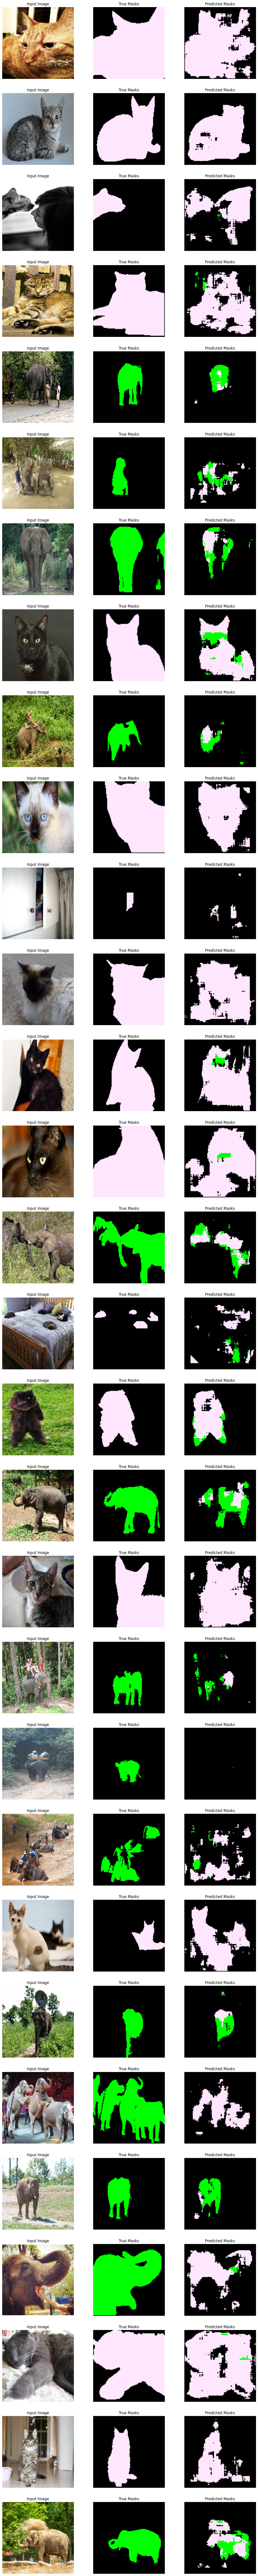

In [7]:
visualize(test_images, test_masks, predict(test_images))

## Statistics

In [8]:
from sklearn.metrics import f1_score

def dice_coefficient(true, pred):
    match_count = 0
    for i in range(len(true)):
        if true[i] == pred[i]:
            match_count += 1
    dice = (2 * match_count) / (len(true) + len(pred))
    return dice


test_images, test_masks = load_data(test_datasets)
predicted_masks = predict(test_images)

y_true, y_pred = [], []

for test_image, test_mask, predicted_mask in zip(test_images, test_masks, predicted_masks):
    test_mask_labels = np.argmax(test_mask, axis=-1).flatten()
    predicted_mask_labels = np.argmax(predicted_mask, axis=-1).flatten()

    y_true.extend(test_mask_labels)
    y_pred.extend(predicted_mask_labels)

micro_f1 = f1_score(y_true, y_pred, average='micro')
print(f"Micro F1 Score: {micro_f1}")

macro_f1 = f1_score(y_true, y_pred, average='macro')
print(f"Macro F1 Score: {macro_f1}")

# Calculate Dice Coefficient
dice_score = dice_coefficient(y_true, y_pred)
print(f"Dice Coefficient: {dice_score}")

# 8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 272ms/step
# Micro F1 Score: 0.789689453125
# Macro F1 Score: 0.6645088211190059
# Dice Coefficient: 0.789689453125

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 311ms/step
Micro F1 Score: 0.789689453125
Macro F1 Score: 0.6645088211190059
Dice Coefficient: 0.789689453125


## Model Through API

In [ ]:
from fastapi import FastAPI, File, UploadFile
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import io
import uvicorn
import nest_asyncio
import numpy as np

app = FastAPI()

@app.post("/predict")
async def apiPredict(file: UploadFile = File(...)):
    contents = await file.read()
    image = Image.open(io.BytesIO(contents))
    image = image.resize((128, 128))
    image_array = img_to_array(image)
    image_array = image_array / 255.0
    image_array = np.expand_dims(image_array, axis=0)

    prediction = predict(image_array)

    return {"mask": prediction.tolist()}

if __name__ == "__main__":
    nest_asyncio.apply()
    uvicorn.run(app)


## Try Your Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


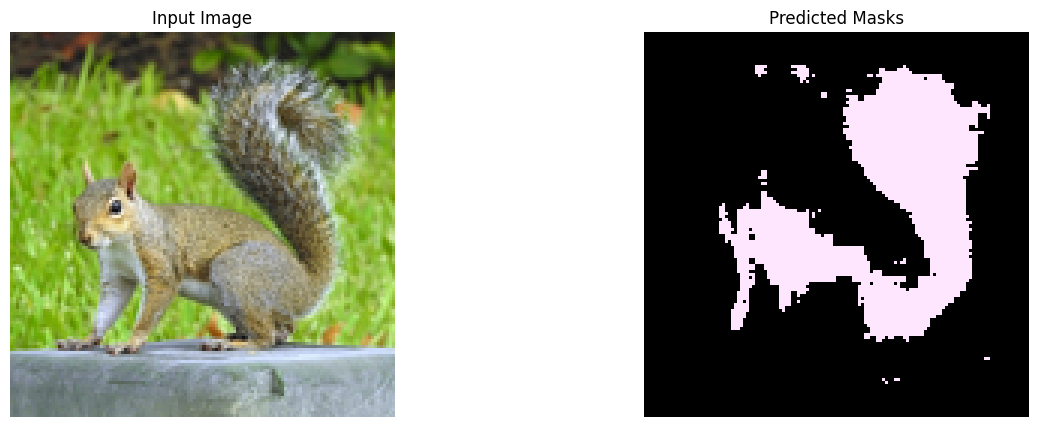

In [12]:
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array


def process_image(image_path):
    image = Image.open(image_path)
    image = image.resize((128, 128))
    image_array = img_to_array(image)
    image_array = image_array / 255.0
    image_array = np.expand_dims(image_array, axis=0)

    prediction = predict(image_array)

    return image_array, prediction


def masks_to_rgb_images(masks, classes=classes):
    colors = [(0, 0, 0), (255, 230, 255), (0, 255, 0), (255, 0, 0), (0, 0, 255), (0, 255, 255)] # black, white, green, red, blue, cyan
    colors.extend([(255, 0, 255), (255, 255, 0),  (255, 165, 0), (128, 0, 128)]) # magenta, yellow, orange, purple
    colors = colors[:len(classes)]

    n_samples, height, width, n_classes = masks.shape
    rgb_images = []

    for i in range(n_samples):
        rgb_image = np.zeros((height, width, 3), dtype=np.uint8)
        for c in range(n_classes):
            # For each class, apply the color to the mask where that class is present
            rgb_image[masks[i, :, :, c] == 1] = colors[c]
        rgb_images.append(rgb_image)
    return rgb_images


def visualize_image_mask(images, predicted_masks):
    predicted_masks = masks_to_rgb_images(predicted_masks)

    plt.figure(figsize=(15, 5 * len(predicted_masks)))
    for i in range(len(predicted_masks)):
        plt.subplot(len(predicted_masks), 2, i * 2 + 1)
        plt.imshow(images[i])
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(len(predicted_masks), 2, i * 2 + 2)
        plt.imshow(predicted_masks[i])
        plt.title('Predicted Masks')
        plt.axis('off')
    plt.show()

# images, masks = process_image('./your-images/0a7eebb5e22fa236.jpg')
# images, masks = process_image('./your-images/0b0e95c13052e55a.jpg')
images, masks = process_image('./your-images/EasternGraySquirrel_GAm.jpg')

visualize_image_mask(images, masks)

## Code Archive

In [ ]:
# Archive

# def load_fiftyone_datasets(split:str, total_max:int, classes=classes):
#     datasets = []
#     max_samples = int(total_max / len(classes))
#     for class_ in classes:
#         dataset = foz.load_zoo_dataset(
#             "open-images-v7",
#             split=split,
#             label_types=["segmentations", "classifications"],
#             classes=classes,
#             max_samples=max_samples,
#             seed=51,
#             shuffle=True,
#             dataset_name=f"fix-0-animals-0-{split}-{class_}"
#         )
#         datasets.append(dataset)
#     return datasets


# train_datasets = load_fiftyone_datasets("train", train_size)
# test_datasets = load_fiftyone_datasets("test", test_size)

# session = fo.launch_app(train_datasets[0].view()) # View the first class
# fo.delete_dataset("animals-train-Cat")

########

# def weighted_categorical_crossentropy(weights):
#     """
#     A weighted version of keras.objectives.categorical_crossentropy

#     Variables:
#         weights: numpy array of shape (C,) where C is the number of classes
#     """
#     weights = tf.constant(weights, dtype='float32')

#     def loss(y_true, y_pred):
#         # scale predictions so that the class probas of each sample sum to 1
#         y_pred /= tf.reduce_sum(y_pred, axis=-1, keepdims=True)
#         # clip to prevent NaN's and Inf's
#         y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
#         # calculate loss and weight loss
#         loss = y_true * tf.math.log(y_pred) * weights
#         loss = -tf.reduce_sum(loss, -1)
#         return loss

#     return loss


# class_weights = [2.0, 0.3, 1.0]
# custom_loss = weighted_categorical_crossentropy(class_weights)
# # Build and compile the model
# model = enhanced_unet_model()
# model.compile(optimizer=Adam(learning_rate=0.001), loss=custom_loss, metrics=['accuracy'])

